# Sport Vouchers Program Analysis

The goal of this Portfolio task is to explore data from the Federal Government Sport Vouchers program - this is a
program that provides up to two $100 vouchers for kids to participate in organised sport. Here's the [NSW Active Kids page](https://www.service.nsw.gov.au/transaction/apply-active-kids-voucher), there are similar schemes in other states - this data is from South Australia.

This is an exercise in exploring data and communicating the insights you can gain from it.  The source data comes
from the `data.gov.au` website and provides details of all Sport Vouchers that have been redeemed since February  in SA 2015 as part of the Sport Voucher program:  [Sports Vouchers Data](https://data.gov.au/dataset/ds-sa-14daba50-04ff-46c6-8468-9fa593b9f100/details).  This download is provided for you as `sportsvouchersclaimed.csv`.

To augment this data you can also make use of [ABS SEIFA data by LGA](http://stat.data.abs.gov.au/Index.aspx?DataSetCode=ABS_SEIFA_LGA#) which shows a few measures of Socioeconomic Advantage and Disadvantage for every Local Government Area. This data is provided for you as `ABS_SEIFA_LGA.csv`. This could enable you to answer questions about whether the voucher program is used equally by parents in low, middle and high socioeconomic areas.   You might be interested in this if you were concerned that this kind of program might just benifit parents who are already advantaged (they might already be paying for sport so this program wouldn't be helping much).

Questions:
* Describe the distribution of vouchers by: LGA, Sport - which regions/sports stand out? 
* Are some sports more popular in different parts of the state?
* Are any LGAs over/under represented in their use of vouchers?
* Is there a relationship between any of the SEIFA measures and voucher use in an LGA?

A challenge in this task is to display a useful summary of the data given that there are a large number of LGAs and sports involved.  Try to avoid long lists and large tables. Think about what plots and tables communicate the main points of your findings. 


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [2]:
# read the sports vouchers data
sa_vouchers = pd.read_csv("files/sportsvouchersclaimed.csv")
sa_vouchers.head()

,Participant_ID,Participant_Suburb,Club_Previous_Member,Participant_ATSI_Indicator,Participant_CALD_Indicator,Participant_Sex,Voucher_Value,Club_Name,Voucher_Sport,Participant_LGA,Participant_Electorate,Voucher_Completion_Date,Voucher_Claim_Year
0,1000002,ABERFOYLE PARK,Registered Previously,Not ATSI,Not CALD,Male,50,Flagstaff Hill Football Club,Australian Rules,ONKAPARINGA,FISHER,26/6/15 1:19,2015
1,1000002,ABERFOYLE PARK,Registered Previously,Not ATSI,Not CALD,Male,50,Flagstaff Hill Football Club,Australian Rules,ONKAPARINGA,FISHER,29/6/16 23:55,2016
2,1000004,ABERFOYLE PARK,Not Registered Previously,Not ATSI,Not CALD,Female,50,Hub Gymnastics Club,Gymnastics,ONKAPARINGA,FISHER,21/4/16 3:37,2016
3,1000004,ABERFOYLE PARK,Registered Previously,Not ATSI,Not CALD,Female,50,Hub Gymnastics Club,Gymnastics,ONKAPARINGA,FISHER,30/3/17 0:47,2017
4,1000005,ABERFOYLE PARK,Registered Previously,Not ATSI,Not CALD,Female,50,Blackwood Community Recreation Association,Gymnastics,ONKAPARINGA,FISHER,20/7/15 2:50,2015


The SEIFA data includes row for each Local Government Area (LGA) but the names of the LGAs have a letter or letters in brackets after the name.  To allow us to match this up with the voucher data we remove this and convert to uppercase. 

For each LGA the data includes a number of measures all of which could be useful in your exploration.  

In [3]:
# read the SEIFA data, create an LGA column by removing the letters in brackets and converting to uppercase
seifa = pd.read_csv('files/ABS_SEIFA_LGA.csv')
lga = seifa["Local Government Areas - 2011"].str.replace(' \([ACSRCDMT]+\)', '').str.upper()
seifa['LGA'] = lga
seifa.head()

,LGA_2011,Local Government Areas - 2011,INDEX_TYPE,Index Type,MEASURE,Measure,Value,LGA
0,10050,Albury (C),IRSAD,Index of Relative Socio-economic Advantage and...,SCORE,Score,967,ALBURY
1,10050,Albury (C),IRSAD,Index of Relative Socio-economic Advantage and...,MINS,Minimum score for SA1s in area,628,ALBURY
2,10050,Albury (C),IRSAD,Index of Relative Socio-economic Advantage and...,MAXS,Maximum score for SA1s in area,1169,ALBURY
3,10050,Albury (C),IRSAD,Index of Relative Socio-economic Advantage and...,URP,Usual resident population,47851,ALBURY
4,10110,Armidale Dumaresq (A),IRSAD,Index of Relative Socio-economic Advantage and...,SCORE,Score,985,ARMIDALE DUMARESQ


Since there are many rows per LGA we need to use `pivot_table` to create a new data frame with one row per LGA. Here
is an example of doing this to create a table with the different SCORE measures and the population (URP) field. 

In [4]:
LGA_scores = seifa[seifa.MEASURE == 'SCORE'].pivot_table(index="LGA", columns=["INDEX_TYPE"], values="Value")
LGA_scores.head()
LGA_pop = seifa[seifa.MEASURE == 'URP'].pivot_table(index="LGA", columns=["INDEX_TYPE"], values="Value")
LGA_scores['Population'] = LGA_pop.IEO
LGA_scores.head()

INDEX_TYPE,IEO,IER,IRSAD,IRSD,Population
LGA,,,,,
ADELAIDE,874.0,874.0,1036.0,1013.0,19606.0
ADELAIDE HILLS,1083.0,1083.0,1077.0,1081.0,38601.0
ALBANY,999.0,999.0,977.0,987.0,33614.0
ALBURY,964.0,964.0,967.0,979.0,47851.0
ALEXANDRINA,1000.0,1000.0,969.0,987.0,23693.0


This data frame can then be joined with the vouchers data fram to create one master data frame containing both the voucher data and the SEIFA measures.

In [5]:
sa_vouchers_scores = sa_vouchers.join(LGA_scores, on='Participant_LGA')
sa_vouchers_scores.head()

,Participant_ID,Participant_Suburb,Club_Previous_Member,Participant_ATSI_Indicator,Participant_CALD_Indicator,Participant_Sex,Voucher_Value,Club_Name,Voucher_Sport,Participant_LGA,Participant_Electorate,Voucher_Completion_Date,Voucher_Claim_Year,IEO,IER,IRSAD,IRSD,Population
0,1000002,ABERFOYLE PARK,Registered Previously,Not ATSI,Not CALD,Male,50,Flagstaff Hill Football Club,Australian Rules,ONKAPARINGA,FISHER,26/6/15 1:19,2015,996.0,996.0,975.0,993.0,159517.0
1,1000002,ABERFOYLE PARK,Registered Previously,Not ATSI,Not CALD,Male,50,Flagstaff Hill Football Club,Australian Rules,ONKAPARINGA,FISHER,29/6/16 23:55,2016,996.0,996.0,975.0,993.0,159517.0
2,1000004,ABERFOYLE PARK,Not Registered Previously,Not ATSI,Not CALD,Female,50,Hub Gymnastics Club,Gymnastics,ONKAPARINGA,FISHER,21/4/16 3:37,2016,996.0,996.0,975.0,993.0,159517.0
3,1000004,ABERFOYLE PARK,Registered Previously,Not ATSI,Not CALD,Female,50,Hub Gymnastics Club,Gymnastics,ONKAPARINGA,FISHER,30/3/17 0:47,2017,996.0,996.0,975.0,993.0,159517.0
4,1000005,ABERFOYLE PARK,Registered Previously,Not ATSI,Not CALD,Female,50,Blackwood Community Recreation Association,Gymnastics,ONKAPARINGA,FISHER,20/7/15 2:50,2015,996.0,996.0,975.0,993.0,159517.0


## Distribution of vouchers by: LGA, Sport 

In [6]:
print(sa_vouchers_scores.shape)
print(sa_vouchers_scores.nunique())

(127526, 18)
Participant_ID                82469
Participant_Suburb             1220
Club_Previous_Member              2
Participant_ATSI_Indicator        2
Participant_CALD_Indicator        2
Participant_Sex                   2
Voucher_Value                    18
Club_Name                      1162
Voucher_Sport                    50
Participant_LGA                  69
Participant_Electorate           48
Voucher_Completion_Date         273
Voucher_Claim_Year                3
IEO                              53
IER                              53
IRSAD                            55
IRSD                             53
Population                       62
dtype: int64


Based on preliminary exploration of the dataset there are 127526 vouchers distributed among 69 LGAs with 50 sports to select from.


Top 5 LGAs by Vouchers
ONKAPARINGA       12782
SALISBURY          8169
TEA TREE GULLY     7219
PLAYFORD           6940
CHARLES STURT      6897
Name: Participant_LGA, dtype: int64 

Bottom 5 LGAs by Vouchers
COOBER PEDY           39
PETERBOROUGH          45
FLINDERS RANGES      102
ORROROO/CARRIETON    137
FRANKLIN HARBOUR     155
Name: Participant_LGA, dtype: int64


(Text(0.5, 0, 'LGA'), Text(0, 0.5, 'Voucher Count'))

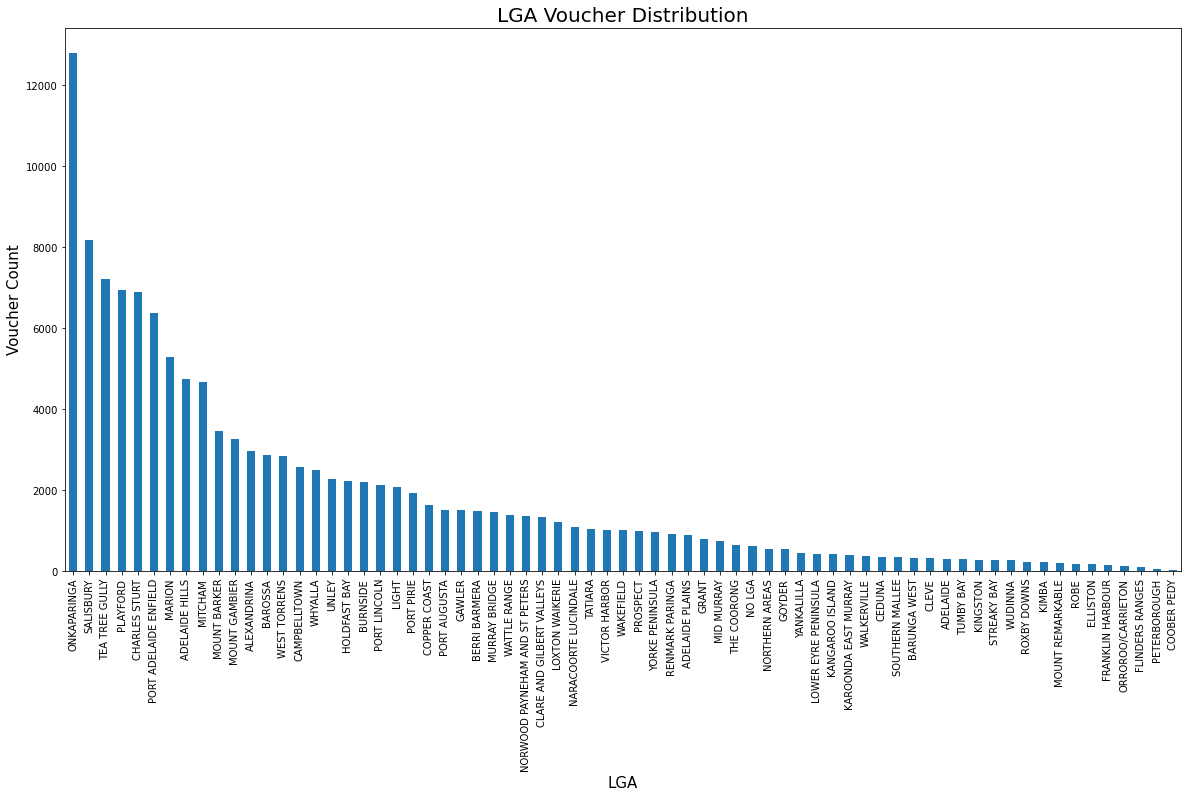

In [7]:
#Significant LGA's
print('\033[1mTop 5 LGAs by Vouchers\033[0m')
LGA_counts=sa_vouchers_scores["Participant_LGA"].value_counts()
print((sa_vouchers_scores["Participant_LGA"].value_counts()).nlargest(5),"\n")

print('\033[1mBottom 5 LGAs by Vouchers\033[0m')
print((sa_vouchers_scores["Participant_LGA"].value_counts()).nsmallest(5))

#Plot
LGA_Plot = LGA_counts.plot(kind='bar',figsize =(20,10))
plt.title("LGA Voucher Distribution", size = 20)
plt.xlabel("LGA", size =15),plt.ylabel("Voucher Count", size = 15)

The highest amount of vouchers are used by the ONKAPARINA LGA which has significantly higher voucher counts than the second highest the SALISBURY LGA; 12782/8169 = 1.56. ONKAPRINGA had ~56% more voucher usage.

Coober Pedy had the least amount of vouchers used (39/12782 = 0.3%) roughly 0.3% of the vouchers used by the top LGA of ONKAPARINGA. Peterborough is also an LGA of note as it has significantly less than the other bottom 5 similiar to COOBER PEDY.

The graph shows a significant skew towards the right indicating that a higher voucher distribution occured in the top few LGAs.

Top 5 Sports by Voucher Usage
Australian Rules     47224
Netball              24017
Football (Soccer)    15775
Gymnastics            9823
Basketball            6016
Name: Voucher_Sport, dtype: int64 

Bottom 5 Sports by Voucher Usage
Bowls               2
Kung Fu (Wu Shu)    2
Dancesport          2
Paralympics         3
Weightlifting       4
Name: Voucher_Sport, dtype: int64 



(Text(0.5, 0, 'Sports'), Text(0, 0.5, 'Voucher Count'))

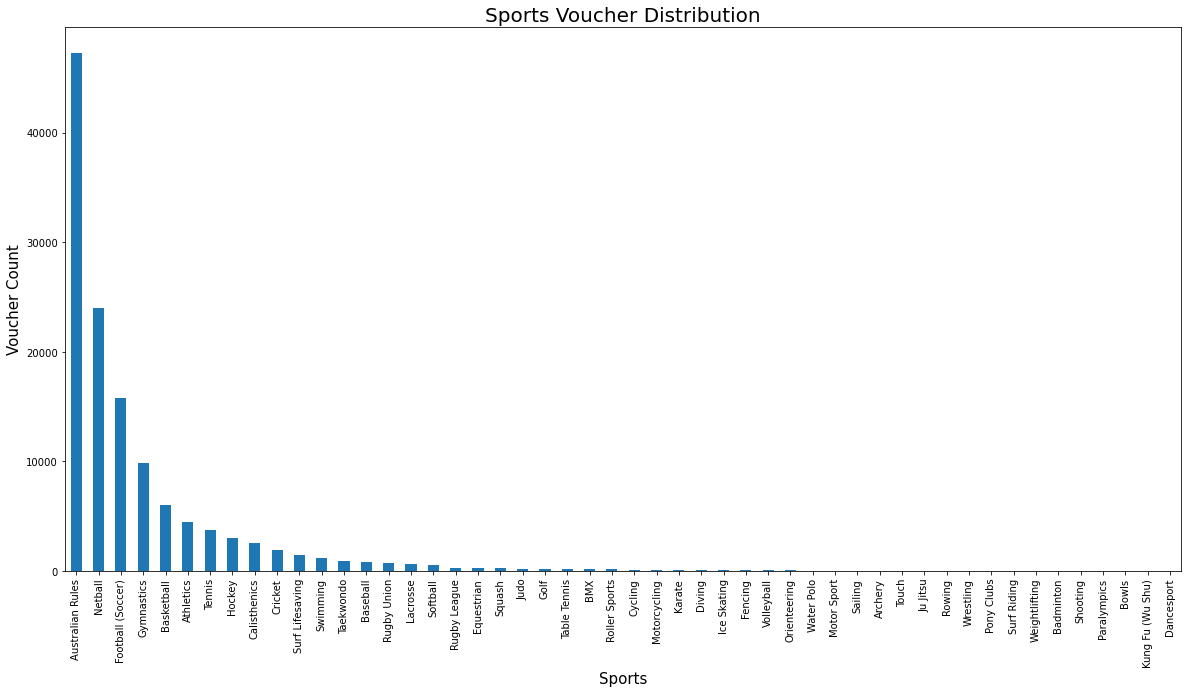

In [8]:
#Significant Sports
print('\033[1mTop 5 Sports by Voucher Usage\033[0m')
print((sa_vouchers_scores["Voucher_Sport"].value_counts()).nlargest(5),"\n")
sport_Counts= sa_vouchers_scores["Voucher_Sport"].value_counts()

print('\033[1mBottom 5 Sports by Voucher Usage\033[0m')
print((sa_vouchers_scores["Voucher_Sport"].value_counts()).nsmallest(5),"\n")

#Plot
sport_Counts.plot(kind='bar',figsize =(20,10))
plt.title("Sports Voucher Distribution", size = 20)
plt.xlabel("Sports", size =15),plt.ylabel("Voucher Count", size = 15)

The most popular sport for vouchers is by far Australian Rules which has significantly higher voucher usage than the second highest Netball; 47224/24017= 1.96.  Australian Rules was selected ~96% more than Netball.

The least popular sport for vouchers is bowls, kung fu and dancesports however the top 5 is closely related in terms of numbers.

Based on the graph it can be seen that out of the 50 sports approximately the vast majority of vouchers were used in the top 10 spots with the main concentration of voucher use being in Australian Rules, Netball and Football. There is an extremely right skew in the graph further exemplifying the concentration of vouchers to be in the top few sports, namely Australian Rules.

## Sport Popularity By LGA

(Text(0.5, 87.0, 'LGA'), Text(159.0, 0.5, 'Sports'))

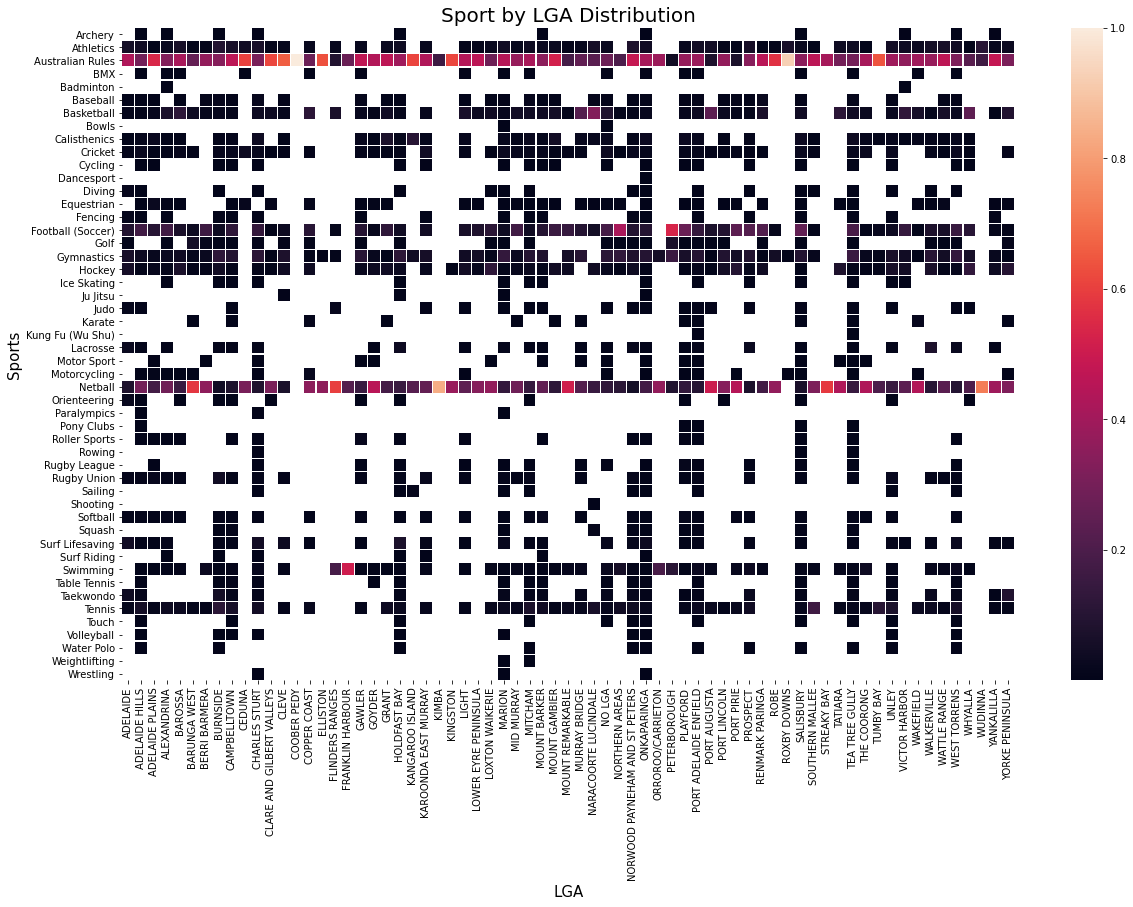

In [9]:
#Voucher Totals
sa_vouchers_scores["voucher_total"] = sa_vouchers_scores.groupby(['Participant_LGA'])['Participant_LGA'].transform('count')
voucher_sport = sa_vouchers_scores.groupby(['Participant_LGA', 'Voucher_Sport',"voucher_total"]).size().reset_index()
voucher_sport['Percentage'] = voucher_sport[0]/voucher_sport['voucher_total']

#Plot Data
LGA_Sports = voucher_sport.drop(voucher_sport.columns[[2, 3]],1)
LGA_Sports_Pivot = LGA_Sports.pivot(index='Voucher_Sport', columns='Participant_LGA', values='Percentage')

#Plot
fig, ax = plt.subplots(figsize =(20,12))
sns.heatmap(LGA_Sports_Pivot, xticklabels=True,yticklabels =True,linewidths=.1)
plt.title("Sport by LGA Distribution", size = 20)
plt.xlabel("LGA", size =15), plt.ylabel("Sports", size = 15)

As consistent with the most popular sports list both Netball and Australian Rules are popular throughout the state. Outlier sports indicating increased preferences outside the norm are swimming in Franklin Harbour, football in the Northern areas and Peterborough.

## Over/Under representation in LGA's

In the above explorations and analysis the LGAs with the most and least voucher distribution was identified, to identify if any LGA's are over or under represented the total vouchers were divided by the total population, LGA's with higher value counts than the expected vouchers based on population are over represented and vice versa for underrepresntation.

In [10]:
#Data Preparation
#Null Check 
sa_vouchers_scores.isna().sum()

Participant_ID                   0
Participant_Suburb               0
Club_Previous_Member             0
Participant_ATSI_Indicator       0
Participant_CALD_Indicator       0
Participant_Sex                  0
Voucher_Value                    0
Club_Name                        0
Voucher_Sport                    0
Participant_LGA                  0
Participant_Electorate           0
Voucher_Completion_Date       2080
Voucher_Claim_Year               0
IEO                           9460
IER                           9460
IRSAD                         9460
IRSD                          9460
Population                    9460
voucher_total                    0
dtype: int64

In [11]:
sa_vouchers_scores.shape

(127526, 19)

In [12]:
clean_sa_vouchers = sa_vouchers_scores
clean_sa_vouchers.dropna(subset = ['Population'], inplace=True)

In [13]:
clean_sa_vouchers.shape

(118066, 19)

As can be seen there are NaN values for certain LGA's population column. The NaN values will be dropped to create a cleaner data set that better represents the overlying data. The rows deleted will amount to 9460 from a total of 127526.

In [14]:
LGA_Clean = clean_sa_vouchers.groupby(["Participant_LGA"])

In [15]:
LGA_Clean['Population'].mean()

Participant_LGA
ADELAIDE           19606.0
ADELAIDE HILLS     38601.0
ALEXANDRINA        23693.0
BAROSSA            22174.0
BARUNGA WEST        2467.0
                    ...   
WEST TORRENS       54932.0
WHYALLA            22070.0
WUDINNA             1256.0
YANKALILLA          4406.0
YORKE PENINSULA    11046.0
Name: Population, Length: 62, dtype: float64

In [16]:
Voucher_Count= LGA_Clean['Participant_LGA'].count()

LGA_Population = pd.DataFrame({'Voucher Count':Voucher_Count.values, 'Population':LGA_Clean['Population'].mean() })
LGA_Population['Population'] = LGA_Clean['Population'].mean()

In [17]:
print(LGA_Population)

                 Voucher Count  Population
Participant_LGA                           
ADELAIDE                   302     19606.0
ADELAIDE HILLS            4756     38601.0
ALEXANDRINA               2979     23693.0
BAROSSA                   2874     22174.0
BARUNGA WEST               333      2467.0
...                        ...         ...
WEST TORRENS              2844     54932.0
WHYALLA                   2488     22070.0
WUDINNA                    267      1256.0
YANKALILLA                 443      4406.0
YORKE PENINSULA            977     11046.0

[62 rows x 2 columns]


In [18]:
LGA_Population['Voucher_per_pop'] = LGA_Population['Voucher Count']/LGA_Population['Population']

In [19]:
print(LGA_Population)

                 Voucher Count  Population  Voucher_per_pop
Participant_LGA                                            
ADELAIDE                   302     19606.0         0.015403
ADELAIDE HILLS            4756     38601.0         0.123209
ALEXANDRINA               2979     23693.0         0.125733
BAROSSA                   2874     22174.0         0.129611
BARUNGA WEST               333      2467.0         0.134982
...                        ...         ...              ...
WEST TORRENS              2844     54932.0         0.051773
WHYALLA                   2488     22070.0         0.112732
WUDINNA                    267      1256.0         0.212580
YANKALILLA                 443      4406.0         0.100545
YORKE PENINSULA            977     11046.0         0.088448

[62 rows x 3 columns]


In [20]:
Avg_voucher_pop = LGA_Population['Voucher_per_pop'].mean()
print("\033[1mAverage Voucher Per Population:\033[0m")
print(Avg_voucher_pop)

Average Voucher Per Population:
0.10384510460162928


all LGA's whos voucher per pop is above the mean is over represented and all LGA's under the mean are underrepresented

In [21]:
overrep = (LGA_Population[LGA_Population['Voucher_per_pop'] > (Avg_voucher_pop)])
underrep= (LGA_Population[LGA_Population['Voucher_per_pop'] < (Avg_voucher_pop)])

In [22]:
overrep.sort_values(by=['Voucher_per_pop'], inplace=True, ascending=False)
print("\033[1mTop 5 Overrepresented LGA's\033[0m")
print(overrep.head())

underrep.sort_values(by=['Voucher_per_pop'], inplace=True, ascending=True)
print("\033[1mTop 5 Underrepresented LGA's\033[0m")
print(underrep.head())
#Degree of over/underrepresentation
LGA_Population['mean_delta'] = (LGA_Population['Voucher_per_pop'] - Avg_voucher_pop)

Top 5 Overrepresented LGA's
                      Voucher Count  Population  Voucher_per_pop
Participant_LGA                                                 
KAROONDA EAST MURRAY            388      1035.0         0.374879
KIMBA                           232      1087.0         0.213431
WUDINNA                         267      1256.0         0.212580
CLEVE                           329      1729.0         0.190283
SOUTHERN MALLEE                 342      2097.0         0.163090
Top 5 Underrepresented LGA's
                 Voucher Count  Population  Voucher_per_pop
Participant_LGA                                            
KINGSTON                   288     72380.5         0.003979
ADELAIDE                   302     19606.0         0.015403
COOBER PEDY                 39      1694.0         0.023022
PETERBOROUGH                45      1733.0         0.025967
CAMPBELLTOWN              2567     97060.0         0.026448


(Text(0.5, 1.0, 'LGA representation'),
 Text(0.5, 0, 'LGA'),
 Text(0, 0.5, 'Delta from Mean'))

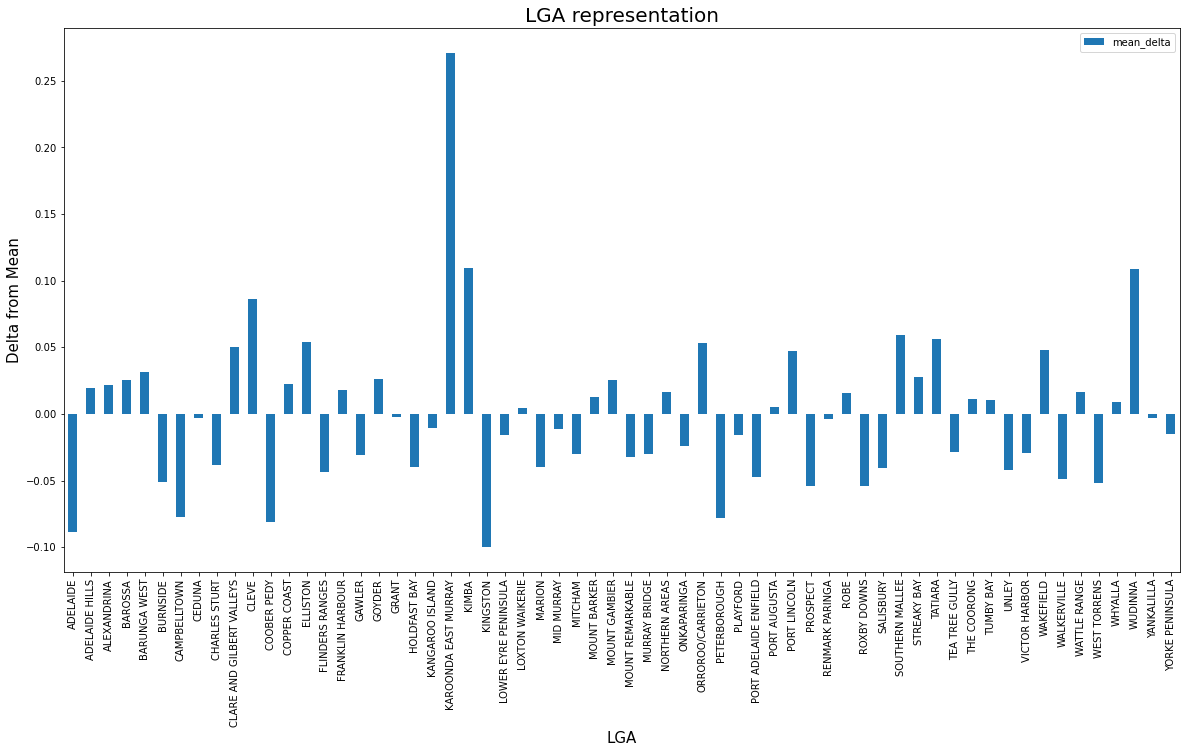

In [23]:
LGA_Population.plot(kind = 'bar', y='mean_delta',figsize=(20,10))
plt.title("LGA representation", size = 20),plt.xlabel("LGA", size =15),plt.ylabel("Delta from Mean", size = 15)

As can be seen certain areas have been significantly over represented in their usage of vouchers per population. Karoonda East Murray has significantly more vouchers per population than any other area beyond expectations. Kingston and Adelaide have a significantly lower amount of vouchers per population than expected. 

The majority of LGA's are within a reasonable range of the mean within 0.05 higher or lower than the mean, however it is evident that a significant portion of the LGA's are severly over or under represented.

## Relation of SEIGA Measures and Voucher use

In [24]:
#Data Preparation
LGA_SEIFA = pd.merge(LGA_Population, LGA_scores, left_index=True, right_index=True)
LGA_SEIFA = LGA_SEIFA.drop(['Voucher Count'],axis =1)
LGA_SEIFA = LGA_SEIFA.drop(['Population_x'],axis =1)
LGA_SEIFA = LGA_SEIFA.drop(['Population_y'],axis =1)

In [25]:
print(LGA_SEIFA)

                 Voucher_per_pop  mean_delta     IEO     IER   IRSAD    IRSD
ADELAIDE                0.015403   -0.088442   874.0   874.0  1036.0  1013.0
ADELAIDE HILLS          0.123209    0.019364  1083.0  1083.0  1077.0  1081.0
ALEXANDRINA             0.125733    0.021888  1000.0  1000.0   969.0   987.0
BAROSSA                 0.129611    0.025766  1028.0  1028.0   997.0  1017.0
BARUNGA WEST            0.134982    0.031137   981.0   981.0   940.0   954.0
...                          ...         ...     ...     ...     ...     ...
WEST TORRENS            0.051773   -0.052072   949.0   949.0   989.0   998.0
WHYALLA                 0.112732    0.008887   905.0   905.0   897.0   905.0
WUDINNA                 0.212580    0.108735  1008.0  1008.0   999.0  1023.0
YANKALILLA              0.100545   -0.003300   990.0   990.0   957.0   972.0
YORKE PENINSULA         0.088448   -0.015397   969.0   969.0   933.0   952.0

[62 rows x 6 columns]


(Text(0.5, 0, 'Voucher per Population'), Text(0, 0.5, 'IRSD'))

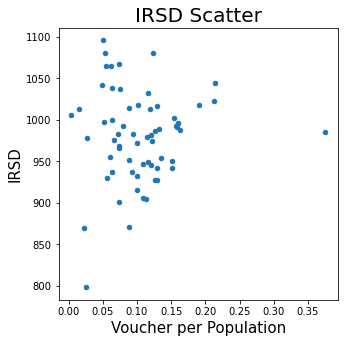

In [26]:
# IRSD Plot
LGA_SEIFA.sort_values(by=['Voucher_per_pop'], inplace=True, ascending=False)
LGA_SEIFA.plot(kind = 'scatter',x='Voucher_per_pop',   y='IRSD',figsize=(5,5) )
plt.title("IRSD Scatter", size = 20)
plt.xlabel("Voucher per Population", size =15),plt.ylabel("IRSD", size = 15)

No correlation or relation can be determined by the scatter plot

(Text(0.5, 0, 'Voucher per Population'), Text(0, 0.5, 'IEO'))

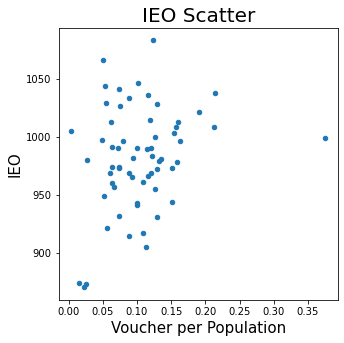

In [27]:
# IEO Plot
LGA_SEIFA.sort_values(by=['Voucher_per_pop'], inplace=True, ascending=False)
LGA_SEIFA.plot(kind = 'scatter',x='Voucher_per_pop',   y='IEO',figsize=(5,5) )
plt.title("IEO Scatter", size = 20)
plt.xlabel("Voucher per Population", size =15),plt.ylabel("IEO", size = 15)

No correlation or relation can be determined by the scatter plot

(Text(0.5, 0, 'Voucher per Population'), Text(0, 0.5, 'IER'))

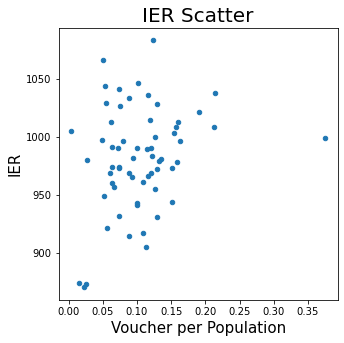

In [28]:
#IER Plot
LGA_SEIFA.sort_values(by=['Voucher_per_pop'], inplace=True, ascending=False)
LGA_SEIFA.plot(kind = 'scatter',x='Voucher_per_pop',   y='IER',figsize=(5,5) )
plt.title("IER Scatter", size = 20)
plt.xlabel("Voucher per Population", size =15),plt.ylabel("IER", size = 15)

No correlation or relation can be determined by the scatter plot

(Text(0.5, 0, 'Voucher per Population'), Text(0, 0.5, 'IRSAD'))

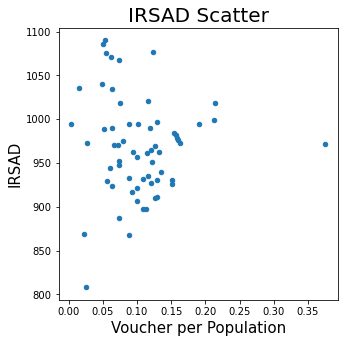

In [29]:
#IRSAD Plot
LGA_SEIFA.sort_values(by=['Voucher_per_pop'], inplace=True, ascending=False)
LGA_SEIFA.plot(kind = 'scatter',x='Voucher_per_pop',   y='IRSAD',figsize=(5,5) )
plt.title("IRSAD Scatter", size = 20)
plt.xlabel("Voucher per Population", size =15),plt.ylabel("IRSAD", size = 15) 

No correlation or relation can be determined by the scatter plot

In [30]:
#Numerical Correlation Analysis
corrIER = LGA_SEIFA['Voucher_per_pop'].corr(LGA_SEIFA['IER'])
corrIEO = LGA_SEIFA['Voucher_per_pop'].corr(LGA_SEIFA['IEO'])
corrIRSAD= LGA_SEIFA['Voucher_per_pop'].corr(LGA_SEIFA['IRSAD'])
corrIRSD= LGA_SEIFA['Voucher_per_pop'].corr(LGA_SEIFA['IRSD'])

print("\033[1mCorrelation between SEIFA Measures and Voucher use\033[0m")
print("Correlation with IRSAD:",corrIRSAD)
print("Correlation with IER:",corrIER)
print("Correlation with IEO:",corrIEO)
print("Correlation with IRSD:",corrIRSD)

Correlation between SEIFA Measures and Voucher use
Correlation with IRSAD: -0.026474405276699045
Correlation with IER: 0.25497177797155335
Correlation with IEO: 0.25497177797155335
Correlation with IRSD: 0.06452436282941924


To further exmeplify the lack of correlation the numerical correlation analysis shows that there appears to be no correlation between any of the SEIFA measures and voucher use. All the SEIFA measures vary from very low to low correlation as the correlation values are under 50.

## Challenge - Queensland

_Note: this is an extra task that you might take on to get a better grade for your portfolio.  You can get a good pass grade without doing this._ 

Queensland has a similar program called [Get Started](https://data.gov.au/dataset/ds-qld-3118838a-d425-48fa-bfc9-bc615ddae44e/details?q=get%20started%20vouchers) and we can retrieve data from their program in a similar format.  

The file [round1-redeemed_get_started_vouchers.csv](files/round1-redeemed_get_started_vouchers.csv) contains records of the vouchers issued in Queensland. The date of this data is not included but the program started in 2015 so it is probably from around then.  

The data includes the LGA of the individual but the name of the activity is slightly different.  To do a comparable analysis you would need to map the activity names onto those from South Australia. 

In [31]:
qld_vouchers = pd.read_csv('files/round1-redeemed_get_started_vouchers.csv')
qld_vouchers.head()

,Application Number,Voucher Number,Child Age (at time of Application),Gender,Has your child played sport before?,Participation Activity,Club Name,Club Suburb/Town,Club Local Government Area Name,Club State Electoral District Name,Parent Suburb/Town,Total Payment
0,2000012253,Q89QDUXP,10,NaN,Yes,*Other,Queensland Police-Citizens Youth Welfare Assoc...,Airlie Beach,Whitsunday (R),Whitsunday,Jubilee Pocket,60.01
1,2000001727,593F6Y41,5,NaN,No,*Other,Guides Queensland,Windsor,Brisbane (C),Brisbane Central,Leichhardt,150.00
2,2000013464,PH2R4RTT,5,NaN,No,*Other,Guides Queensland,Windsor,Brisbane (C),Brisbane Central,Woodridge,150.00
3,2000009270,035SE2H5,5,NaN,Yes,*Other,Guides Queensland,Windsor,Brisbane (C),Brisbane Central,Yatala,150.00
4,2000007273,NP6C4729,6,NaN,No,*Other,Guides Queensland,Windsor,Brisbane (C),Brisbane Central,Alexandra Hills,150.00


In [32]:
# Join the QLD data with the LGA data as before to get population and SIEFA data integrated
qld_vouchers['LGA'] = qld_vouchers['Club Local Government Area Name'].str.replace(' \([RC]+\)', '').str.upper()
qld_vouchers_scores = qld_vouchers.join(LGA_scores, on='LGA')
qld_vouchers_scores.head()

,Application Number,Voucher Number,Child Age (at time of Application),Gender,Has your child played sport before?,Participation Activity,Club Name,Club Suburb/Town,Club Local Government Area Name,Club State Electoral District Name,Parent Suburb/Town,Total Payment,LGA,IEO,IER,IRSAD,IRSD,Population
0,2000012253,Q89QDUXP,10,NaN,Yes,*Other,Queensland Police-Citizens Youth Welfare Assoc...,Airlie Beach,Whitsunday (R),Whitsunday,Jubilee Pocket,60.01,WHITSUNDAY,989.0,989.0,966.0,982.0,31393.0
1,2000001727,593F6Y41,5,NaN,No,*Other,Guides Queensland,Windsor,Brisbane (C),Brisbane Central,Leichhardt,150.00,BRISBANE,1018.0,1018.0,1057.0,1048.0,1042074.0
2,2000013464,PH2R4RTT,5,NaN,No,*Other,Guides Queensland,Windsor,Brisbane (C),Brisbane Central,Woodridge,150.00,BRISBANE,1018.0,1018.0,1057.0,1048.0,1042074.0
3,2000009270,035SE2H5,5,NaN,Yes,*Other,Guides Queensland,Windsor,Brisbane (C),Brisbane Central,Yatala,150.00,BRISBANE,1018.0,1018.0,1057.0,1048.0,1042074.0
4,2000007273,NP6C4729,6,NaN,No,*Other,Guides Queensland,Windsor,Brisbane (C),Brisbane Central,Alexandra Hills,150.00,BRISBANE,1018.0,1018.0,1057.0,1048.0,1042074.0


## Data Preparation

To create comparable data sets for analysis the Qld sports data is mapped to that of the SA sports data. Any sports unmappable or uncommon to both datasets are dropped.

In [33]:
#All Sports in QLD Data
print(qld_vouchers_scores['Participation Activity'].unique())

['*Other' 'Archery' 'Athletics' 'Australian Football' 'Baseball'
 'Basketball' 'BMX Bicycle Motocross' 'Body Boarding' 'Bowls Lawn'
 'Boxing' 'Broomball' 'Bushwalking' 'Calisthenics' 'Canoeing Outrigger'
 'Cheerleading' 'Cricket' 'Cycling' 'Dancesport' 'Disability Sports'
 'Dragon Boating' 'Equestrian' 'Football (Soccer)' 'Futsal' 'Golf'
 'Gymnastics' 'Hockey' 'Ice Hockey' 'Ice Skating' 'Inline Hockey'
 'Ju Jitsu' 'Judo' 'Karate' 'Karting' 'Kayaking' 'Life Saving Surf'
 'Mixed Martial Arts' 'Motor Cycling' 'Netball' 'Oztag' 'Parkour'
 'Polocrosse' 'Pony Club' 'Riding for the Disabled' 'Rock Climbing'
 'Roller Sports' 'Rowing' 'Rugby League' 'Rugby Union' 'Sailing'
 'Shooting' 'Skipping' 'Softball' 'Squash' 'Surfing' 'Swimming'
 'Swimming Synchronised' 'Table Tennis' 'Taekwondo' 'T-Ball' 'Tennis'
 'Tenpin Bowling' 'Touch' 'Trail Bike Riding' 'Trampolining'
 'Weightlifting' 'Zen Do Kai Martial Arts']


In [34]:
#All Sports in SA Data
print(sa_vouchers_scores['Voucher_Sport'].unique())

['Australian Rules' 'Gymnastics' 'Basketball' 'Netball' 'Golf'
 'Calisthenics' 'Cricket' 'Tennis' 'Surf Lifesaving' 'Fencing'
 'Football (Soccer)' 'Taekwondo' 'Table Tennis' 'Athletics' 'Lacrosse'
 'Rugby League' 'BMX' 'Hockey' 'Ju Jitsu' 'Baseball' 'Diving' 'Softball'
 'Swimming' 'Judo' 'Volleyball' 'Rugby Union' 'Orienteering' 'Ice Skating'
 'Cycling' 'Archery' 'Dancesport' 'Equestrian' 'Motorcycling'
 'Roller Sports' 'Touch' 'Karate' 'Motor Sport' 'Squash' 'Water Polo'
 'Surf Riding' 'Weightlifting' 'Pony Clubs' 'Rowing' 'Wrestling' 'Sailing'
 'Badminton' 'Kung Fu (Wu Shu)' 'Paralympics' 'Bowls']


In [35]:
#Dictionary to transform QLD sports to SA sports and seperate dictionary to store all common sports
dictTransform = {'Australian Football': 'Australian Rules','Gymnastics':'Gymnastics', 'Basketball':'Basketball', 'Netball':'Netball',
          'Golf':'Golf','Calisthenics':'Calisthenics','Cricket':'Cricket', 'Tennis':'Tennis','Life Saving Surf':'Surf Lifesaving','Football (Soccer)':'Football (Soccer)',
                'Taekwondo':'Taekwondo','Table Tennis':'Table Tennis','Athletics':'Athletics', 'Rugby League':'Rugby League','BMX Bicycle Motocross':'BMX',
                'Hockey':'Hockey','Ju Jitsu':'Ju Jitsu','Baseball':'Baseball','Softball':'Softball','Swimming':'Swimming','Judo':'Judo',
                'Rugby Union':'Rugby Union','Ice Skating':'Ice Skating','Cycling':'Cycling','Archery':'Archery','Dancesport':'Dancesport',
                'Equestrian':'Equestrian','Motor Cycling':'Motorcycling','Roller Sports':'Roller Sports','Touch':'Touch','Karate':'Karate',
                'Squash':'Squash','Surfing':'Surf Riding','Weightlifting':'Weightlifting','Pony Club':'Pony Clubs','Rowing':'Rowing',
                'Sailing':'Sailing','Shooting':'Shooting','Bowls Lawn':'Bowls'}

dictCommon = {'Australian Rules':'Australian Rules','Gymnastics':'Gymnastics','Basketball':'Basketball','Netball':'Netball',
               'Golf':'Golf','Calisthenics':'Calisthenics','Cricket':'Cricket','Tennis':'Tennis','Football (Soccer)':'Football (Soccer)',
             'Taekwondo':'Taekwondo','Table Tennis':'Table Tennis','Athletics':'Athletics','Rugby League':'Rugby League','BMX':'BMX','Hockey':'Hockey',
             'Ju Jitsu':'Ju Jitsu','Baseball':'Baseball','Softball':'Softball','Swimming':'Swimming','Judo':'Judo','Rugby Union':'Rugby Union',
             'Ice Skating':'Ice Skating','Cycling':'Cycling','Archery':'Archery','Dancesport':'Dancesport','Equestrian':'Equestrian','Motorcycling':'Motorcycling',
             'Roller Sports':'Roller Sports','Touch':'Touch','Karate':'Karate','Squash':'Squash','Surf Riding':'Surf Riding','Weightlifting':'Weightlifting',
             'Pony Clubs':'Pony Clubs','Rowing':'Rowing','Sailing':'Sailing','Shooting':'Shooting','Bowls':'Bowls'}



In [36]:
qld_vouchers_scores['Participation Activity'] = qld_vouchers_scores['Participation Activity'].map(dictTransform)

In [37]:
sa_vouchers_scores['Voucher_Sport'] = sa_vouchers_scores['Voucher_Sport'].map(dictCommon)

In [38]:
qld_vouchers_scores.dropna(subset = ['Participation Activity'], inplace=True)

In [39]:
sa_vouchers_scores.dropna(subset = ['Voucher_Sport'], inplace=True)

In [40]:
qld_vouchers_scores.isna().sum()

Application Number                        0
Voucher Number                            0
Child Age (at time of Application)        0
Gender                                 9199
Has your child played sport before?       3
Participation Activity                    0
Club Name                                 0
Club Suburb/Town                          0
Club Local Government Area Name           0
Club State Electoral District  Name       0
Parent Suburb/Town                        0
Total Payment                             0
LGA                                       0
IEO                                     515
IER                                     515
IRSAD                                   515
IRSD                                    515
Population                              515
dtype: int64

In [41]:
qld_vouchers_scores.head()

,Application Number,Voucher Number,Child Age (at time of Application),Gender,Has your child played sport before?,Participation Activity,Club Name,Club Suburb/Town,Club Local Government Area Name,Club State Electoral District Name,Parent Suburb/Town,Total Payment,LGA,IEO,IER,IRSAD,IRSD,Population
13,2000010829,X784DOAP,12,NaN,Yes,Archery,Hinchinbrook Bowmen Inc,Ingham,Hinchinbrook (S),Hinchinbrook,Ingham,40.0,HINCHINBROOK (S),NaN,NaN,NaN,NaN,NaN
14,2000011952,LZIRY6XS,7,NaN,No,Archery,Gympie Field Archers Association Inc,Imbil,Gympie (R),Gympie,The Palms,130.0,GYMPIE,962.0,962.0,916.0,929.0,45749.0
15,2000006332,DH5FNQKS,9,NaN,No,Archery,Gympie Field Archers Association Inc,Imbil,Gympie (R),Gympie,Curra,130.0,GYMPIE,962.0,962.0,916.0,929.0,45749.0
16,2000006325,NPKP5E1X,10,NaN,No,Archery,Gympie Field Archers Association Inc,Imbil,Gympie (R),Gympie,Curra,130.0,GYMPIE,962.0,962.0,916.0,929.0,45749.0
17,2000001140,X332JQI2,14,NaN,Yes,Archery,Gympie Field Archers Association Inc,Imbil,Gympie (R),Gympie,Cooran,130.0,GYMPIE,962.0,962.0,916.0,929.0,45749.0


# Comparable Analysis

## LGA Distribution

In [42]:
print('\033[1mTop 5 LGAs in SA\033[0m')
print((sa_vouchers_scores["Participant_LGA"].value_counts()).nlargest(5),"\n")

Top 5 LGAs in SA
ONKAPARINGA       12271
SALISBURY          8116
TEA TREE GULLY     7192
PLAYFORD           6914
CHARLES STURT      6432
Name: Participant_LGA, dtype: int64 



In [43]:
print('\033[1mTop 5 LGAs in QLD\033[0m')
print((qld_vouchers_scores['LGA'].value_counts()).nlargest(5),"\n")

Top 5 LGAs in QLD
GOLD COAST        1686
BRISBANE          1252
SUNSHINE COAST     965
MORETON BAY        932
LOGAN              768
Name: LGA, dtype: int64 



In [44]:
# Plot Data
saPlot_LGA = sa_vouchers_scores['Participant_LGA'].value_counts()
qldPlot_LGA = qld_vouchers_scores['LGA'].value_counts()

(Text(0.5, 0, 'LGA'), Text(0, 0.5, 'Voucher Count'))

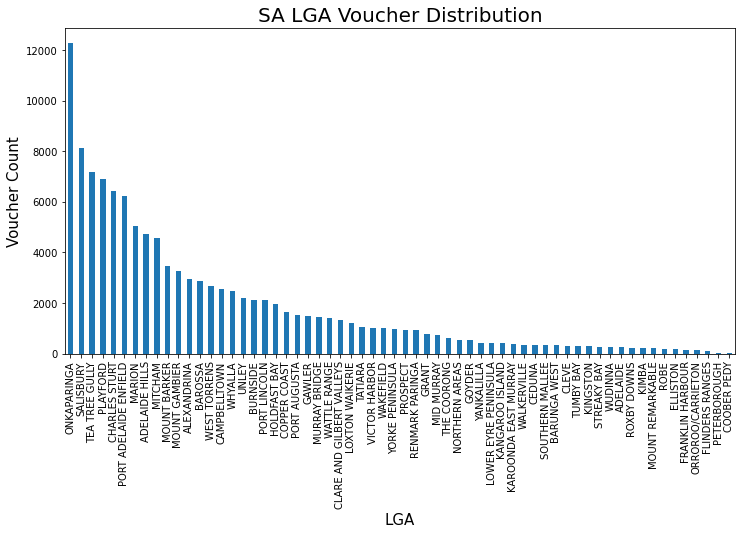

In [45]:
#SA Plot
saPlot_LGA.plot(kind='bar',figsize =(12,6))
plt.title("SA LGA Voucher Distribution", size = 20)
plt.xlabel("LGA", size =15),plt.ylabel("Voucher Count", size = 15)

(Text(0.5, 0, 'LGA'), Text(0, 0.5, 'Voucher Count'))

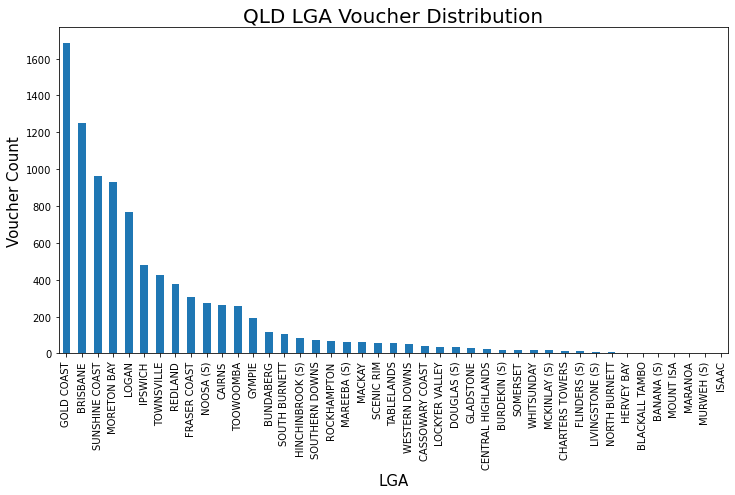

In [46]:
#QLD Plot
qldPlot_LGA.plot(kind='bar',figsize =(12,6))
plt.title("QLD LGA Voucher Distribution", size = 20)
plt.xlabel("LGA", size =15),plt.ylabel("Voucher Count", size = 15)

Distribution follows a similiar trend across both SA and QLD.

## Sports Distribution

In [47]:
print('\033[1mTop 5 Sports in SA\033[0m')
print((sa_vouchers_scores["Voucher_Sport"].value_counts()).nlargest(5),"\n")

Top 5 Sports in SA
Australian Rules     44043
Netball              21642
Football (Soccer)    14544
Gymnastics            9389
Basketball            5403
Name: Voucher_Sport, dtype: int64 



In [48]:
print('\033[1mTop 5 Sports in QLD\033[0m')
print((qld_vouchers_scores['Participation Activity'].value_counts()).nlargest(5),"\n")

Top 5 Sports in QLD
Rugby League         2782
Football (Soccer)    2074
Netball              1263
Australian Rules      548
Gymnastics            539
Name: Participation Activity, dtype: int64 



Australian Rules, Gymnastics, Football and Netball continue to be the top 5 sports for both Areas as the most popular however it seems as though out of the available sports SA prefers Australian Rules significantly more than QLD who prefers Rugby LEague. It is also important to note that the proportion that Australian Rules is popular by is greater than rugby league in QLD. QLD's sports distribution is distributed more evenly across multiple sports as opposed to SA.

In [49]:
# Plot Data
saPlot_sports = sa_vouchers_scores['Voucher_Sport'].value_counts()
qldPlot_sports = qld_vouchers_scores['Participation Activity'].value_counts()

(Text(0.5, 0, 'Sport'), Text(0, 0.5, 'Voucher Count'))

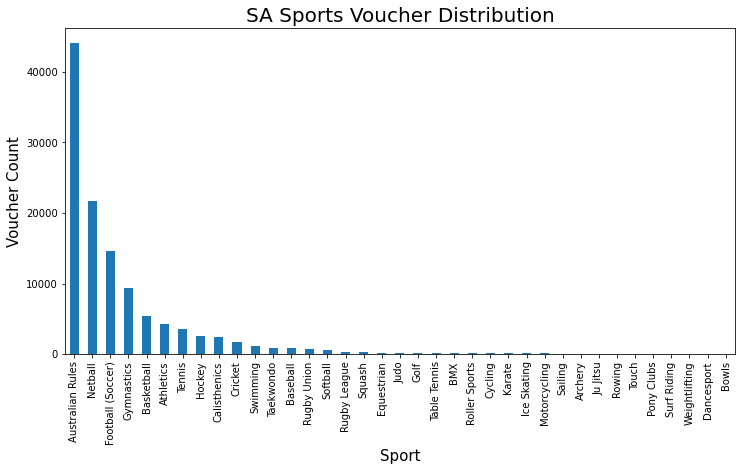

In [50]:
#SA Plot
saPlot_sports.plot(kind='bar',figsize =(12,6))
plt.title("SA Sports Voucher Distribution", size = 20)
plt.xlabel("Sport", size =15),plt.ylabel("Voucher Count", size = 15)

(Text(0.5, 0, 'Sport'), Text(0, 0.5, 'Voucher Count'))

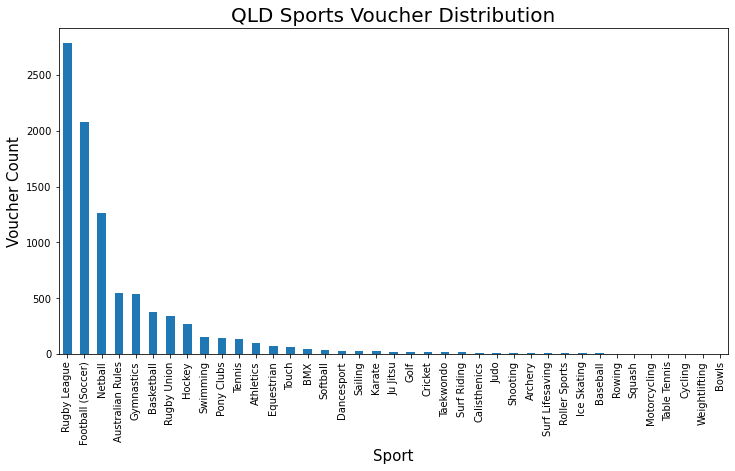

In [51]:
#QLD Plot
qldPlot_sports.plot(kind='bar',figsize =(12,6))
plt.title("QLD Sports Voucher Distribution", size = 20)
plt.xlabel("Sport", size =15),plt.ylabel("Voucher Count", size = 15)

The distribution of vouicher use on sports is relatively similiar with the majority of voucher use in the top 3 sports heavily skewed to the right. However proportionally Qld is more evened out in the top 3 sports.

## Over/Under representation in LGA's

In [52]:
#Data Preparation
#Null Check
qld_vouchers_scores.isna().sum()

Application Number                        0
Voucher Number                            0
Child Age (at time of Application)        0
Gender                                 9199
Has your child played sport before?       3
Participation Activity                    0
Club Name                                 0
Club Suburb/Town                          0
Club Local Government Area Name           0
Club State Electoral District  Name       0
Parent Suburb/Town                        0
Total Payment                             0
LGA                                       0
IEO                                     515
IER                                     515
IRSAD                                   515
IRSD                                    515
Population                              515
dtype: int64

In [53]:
#Data Cleaning
clean_qld_vouchers = qld_vouchers_scores
clean_qld_vouchers.dropna(subset = ['Population'], inplace=True)

In [54]:
clean_qld_vouchers.shape

(8684, 18)

In [55]:
qld_clean_lga =clean_qld_vouchers.groupby(["LGA"])

In [56]:
qld_lga_count= qld_clean_lga['LGA'].count()

In [57]:
qld_Lga = pd.DataFrame({'Voucher Count':qld_lga_count.values, 'Population':qld_clean_lga['Population'].mean() })
qld_Lga['Population'] = qld_clean_lga['Population'].mean()

In [58]:
qld_Lga['Voucher_per_pop'] = qld_Lga['Voucher Count']/qld_Lga['Population']

In [59]:
qld_voucherpop_avg = qld_Lga['Voucher_per_pop'].mean()

In [60]:
overrepQLD = (qld_Lga[qld_Lga['Voucher_per_pop'] > (qld_voucherpop_avg)])
underrepQLD= (qld_Lga[qld_Lga['Voucher_per_pop'] < (qld_voucherpop_avg)])

In [61]:
overrepQLD.sort_values(by=['Voucher_per_pop'], inplace=True, ascending=False)
print("\033[1mTop 5 QLD Overrepresented LGA's\033[0m")
print(overrepQLD.head())

underrepQLD.sort_values(by=['Voucher_per_pop'], inplace=True, ascending=True)
print("\033[1mTop 5 QLD Underrrepresented LGA's\033[0m")
print(underrepQLD.head())
#Degree of over/underrepresentation
qld_Lga['mean_delta'] = (qld_Lga['Voucher_per_pop'] - qld_voucherpop_avg)

print("\033[1mTop 5 SA Overrepresented LGA's\033[0m")
print(overrep.head(),"\n")

print("\033[1mTop 5 SA Underrepresented LGA's\033[0m")
print(underrep.head())

Top 5 QLD Overrepresented LGA's
                Voucher Count  Population  Voucher_per_pop
LGA                                                       
GYMPIE                    190     45749.0         0.004153
SOUTH BURNETT             107     31006.0         0.003451
GOLD COAST               1686    494591.0         0.003409
FRASER COAST              307     95348.0         0.003220
SUNSHINE COAST            965    306889.0         0.003144
Top 5 QLD Underrrepresented LGA's
           Voucher Count  Population  Voucher_per_pop
LGA                                                  
ISAAC                  1     22568.0         0.000044
MOUNT ISA              3     21237.0         0.000141
MARANOA                2     13078.0         0.000153
GLADSTONE             28     57874.0         0.000484
MACKAY                61    112812.0         0.000541
Top 5 SA Overrepresented LGA's
                      Voucher Count  Population  Voucher_per_pop
Participant_LGA                                

(Text(0.5, 1.0, 'QLD LGA representation'),
 Text(0.5, 0, 'LGA'),
 Text(0, 0.5, 'Delta from Mean'))

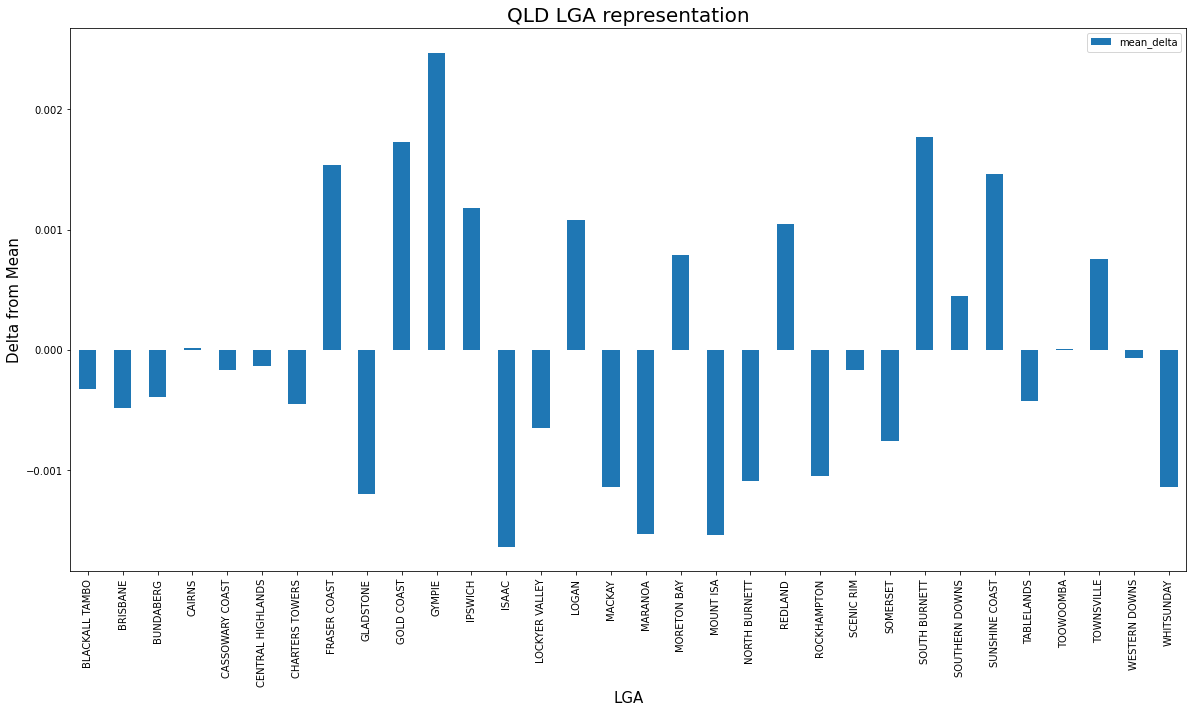

In [62]:
qld_Lga.plot(kind = 'bar', y='mean_delta',figsize=(20,10))
plt.title("QLD LGA representation", size = 20),plt.xlabel("LGA", size =15),plt.ylabel("Delta from Mean", size = 15)

(Text(0.5, 1.0, 'SA LGA representation'),
 Text(0.5, 0, 'LGA'),
 Text(0, 0.5, 'Delta from Mean'))

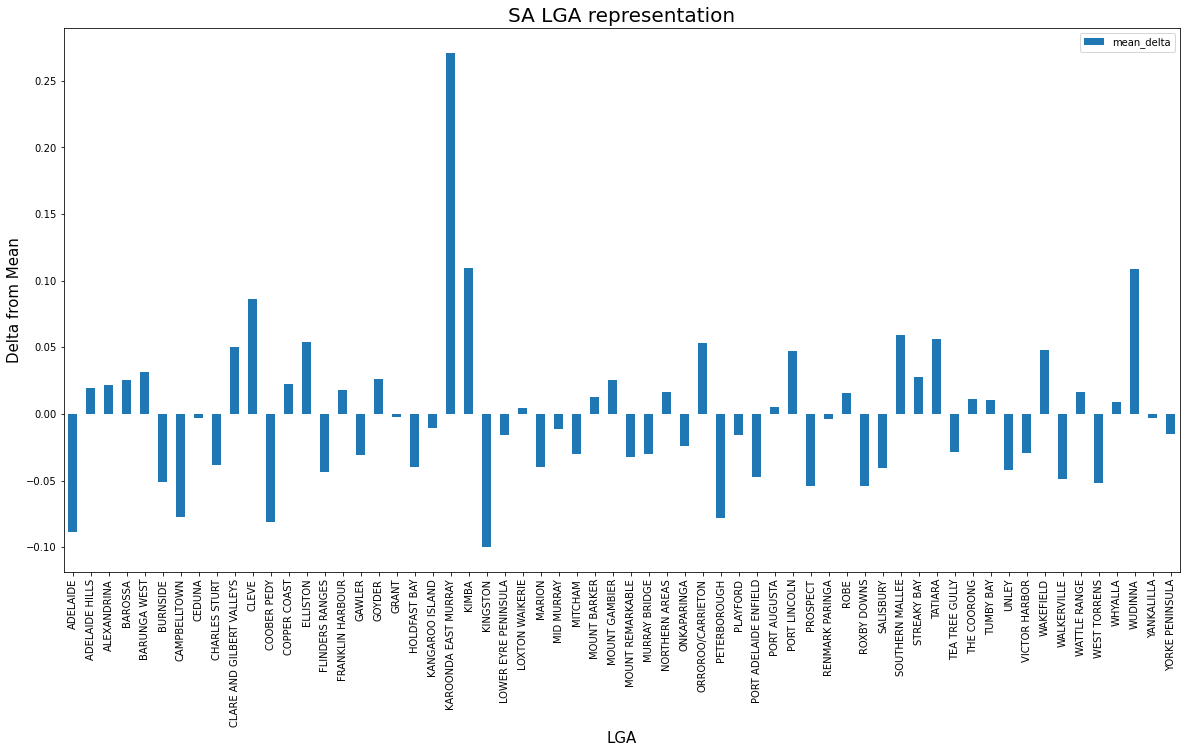

In [63]:
LGA_Population.plot(kind = 'bar', y='mean_delta',figsize=(20,10))
plt.title("SA LGA representation", size = 20),plt.xlabel("LGA", size =15),plt.ylabel("Delta from Mean", size = 15)

The SA data has significant over and under representation of several LGA's while on the other hand QLDs distribution of vouchers is significantly more equal with no over or under representation of LGA's. The vouchers have been consistently distributed based on population unlike SA.

## Relation of SEIFA Measures and Voucher use


In [64]:
QLD_Seifa = pd.merge(qld_Lga, LGA_scores, left_index=True, right_index=True)
QLD_Seifa=QLD_Seifa.drop(['Voucher Count'],axis =1)
QLD_Seifa=QLD_Seifa.drop(['Population_x'],axis =1)
QLD_Seifa=QLD_Seifa.drop(['Population_y'],axis =1)

(Text(0.5, 0, 'Voucher per Population'), Text(0, 0.5, 'IRSD'))

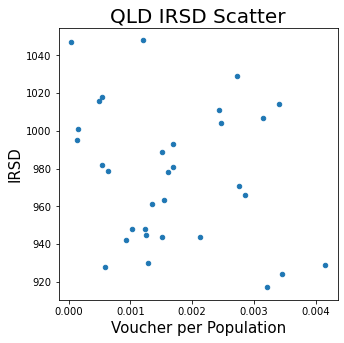

In [65]:
# IRSD Plot
QLD_Seifa.sort_values(by=['Voucher_per_pop'], inplace=True, ascending=False)
QLD_Seifa.plot(kind = 'scatter',x='Voucher_per_pop',   y='IRSD',figsize=(5,5) )
plt.title("QLD IRSD Scatter", size = 20)
plt.xlabel("Voucher per Population", size =15),plt.ylabel("IRSD", size = 15)

No correlation or relation can be determined by the scatter plot

(Text(0.5, 0, 'Voucher per Population'), Text(0, 0.5, 'IEO'))

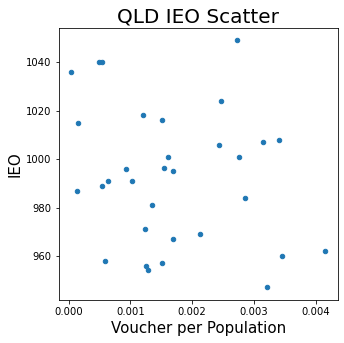

In [66]:
# IEO Plot
QLD_Seifa.sort_values(by=['Voucher_per_pop'], inplace=True, ascending=False)
QLD_Seifa.plot(kind = 'scatter',x='Voucher_per_pop',   y='IEO',figsize=(5,5) )
plt.title("QLD IEO Scatter", size = 20)
plt.xlabel("Voucher per Population", size =15),plt.ylabel("IEO", size = 15)

No correlation or relation can be determined by the scatter plot

(Text(0.5, 0, 'Voucher per Population'), Text(0, 0.5, 'IER'))

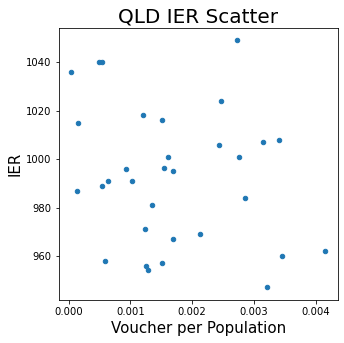

In [67]:
#IER Plot
QLD_Seifa.sort_values(by=['Voucher_per_pop'], inplace=True, ascending=False)
QLD_Seifa.plot(kind = 'scatter',x='Voucher_per_pop',   y='IER',figsize=(5,5) )
plt.title("QLD IER Scatter", size = 20)
plt.xlabel("Voucher per Population", size =15),plt.ylabel("IER", size = 15)

No correlation or relation can be determined by the scatter plot

(Text(0.5, 0, 'Voucher per Population'), Text(0, 0.5, 'IRSAD'))

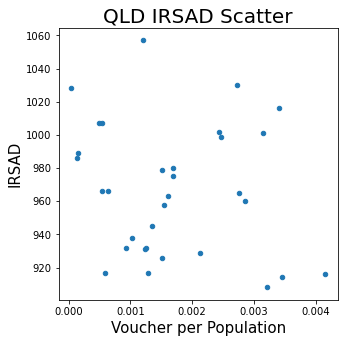

In [68]:
#IRSAD Plot
QLD_Seifa.sort_values(by=['Voucher_per_pop'], inplace=True, ascending=False)
QLD_Seifa.plot(kind = 'scatter',x='Voucher_per_pop',   y='IRSAD',figsize=(5,5) )
plt.title("QLD IRSAD Scatter", size = 20)
plt.xlabel("Voucher per Population", size =15),plt.ylabel("IRSAD", size = 15) 

No correlation or relation can be determined by the scatter plot

In [69]:
#Numerical Correlation Analysis
corrIERQLD = QLD_Seifa['Voucher_per_pop'].corr(QLD_Seifa['IER'])
corrIEOQLD = QLD_Seifa['Voucher_per_pop'].corr(QLD_Seifa['IEO'])
corrIRSADQLD = QLD_Seifa['Voucher_per_pop'].corr(QLD_Seifa['IRSAD'])
corrIRSDQLD = QLD_Seifa['Voucher_per_pop'].corr(QLD_Seifa['IRSD'])

print("\033[1mCorrelation between SEIFA Measures and Voucher use in QLD\033[0m")
print("Correlation with IRSAD:",corrIRSADQLD)
print("Correlation with IER:",corrIERQLD)
print("Correlation with IEO:",corrIERQLD)
print("Correlation with IRSD:",corrIRSDQLD)

#Numerical Correlation Analysis
print("\033[1mCorrelation between SEIFA Measures and Voucher use in SA\033[0m")
print("Correlation with IRSAD:",corrIRSAD)
print("Correlation with IER:",corrIER)
print("Correlation with IEO:",corrIEO)
print("Correlation with IRSD:",corrIRSD)

Correlation between SEIFA Measures and Voucher use in QLD
Correlation with IRSAD: -0.16348881120900133
Correlation with IER: -0.2170043179192273
Correlation with IEO: -0.2170043179192273
Correlation with IRSD: -0.23328150733172137
Correlation between SEIFA Measures and Voucher use in SA
Correlation with IRSAD: -0.026474405276699045
Correlation with IER: 0.25497177797155335
Correlation with IEO: 0.25497177797155335
Correlation with IRSD: 0.06452436282941924


As with the SA data there is little correlation or relationship between SEIFA measures and voucher use in QLD. It is also important to note that although a very weak correlation exists in the QLD data set it is a negative correlation as opposed to the SA data.